# Homeworks
1. Find the answer to the question raised in the lab1

    Some helpful resources:
- DeepWalk: https://arxiv.org/pdf/1403.6652.pdf
- Word2vec: https://arxiv.org/pdf/1301.3781.pdf
- Repository Github of Word2vec at [this link](https://github.com/RaRe-Technologies/gensim)
2. Implement a simple word2vec algorithm for the DeepWalk (Attributes for each node should be created).
3. Use some libraries to solve a real problem

# Answer

As you see in the papers, the goals of Word2vec fit the DeepWalk algorithm. Besides, in the original DeepWalk paper, the authors use SkipGram, which is implemented in the Word2vec library. Therefore, we could use a ready-made function to implement DeepWalk. 

But in this lab, we will implement a simple Word2vec function.

## Implement Word2vec

### Download data and install packages

In [ ]:
!pip install umap-learn
!pip install karateclub==1.0.22
!pip install gensim==3.6

     |████████████████████████████████| 80 kB 2.8 MB/s 
     |████████████████████████████████| 1.1 MB 28.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76564 sha256=b70f18f8b8a5ff2b0e3b47287513db49671b5d370a73867b534e8322b4d4f190
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52373 sha256=47dd908de9e4200cf3be8457af7f6094beff319cecfe0343ef1351b6ccb03d54
  Stored in directory: /root/.cache/pip/wheels/d0/5b/62/3401692ddad12324249c774c4b15ccb046946021e2b581c043
Successfully built umap-learn pynndescent
     |████████████████████████████████| 56 kB 2.3 MB/s 
     |████████████████████████████████| 1.8 MB 7.4 MB/s 
     |████████████████████████████████| 24.2 MB 99 kB/s 
  Created wheel for karateclub: filename=karateclub-1.0.22-py3-none-any.whl size=93252 sha256=c5ec475a4342d04a293b6f093f5ce7da0ff0eea25b611ec4

Please restart runtime after installing numpy

In [ ]:
!gdown --id "1RmrHId0d-uY7kJCSgCtNYbwYfp4Oum3c&export=download"
!unrar x -Y "/content/lab3.rar" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=1RmrHId0d-uY7kJCSgCtNYbwYfp4Oum3c&export=download
To: /content/lab3.rar
100% 1.54M/1.54M [00:00<00:00, 74.1MB/s]

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/lab3.rar

Extracting  /content/lab3_attributes.csv                                   0%  OK 
Extracting  /content/facebook_features.json                               28%  OK 
Extracting  /content/facebook_target.csv                                  59%  OK 
Extracting  /content/lab3_edgelist.txt                                    59%  OK 
Extracting  /content/facebook_edges.csv                                   99%  OK 
All OK


### Packages

In [ ]:
# Task 1
import networkx as nx
from joblib import Parallel, delayed
import random
import itertools
import numpy as np
import pandas as pd

# Task 2
import json
import umap
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns

### Utils

In [ ]:
def partition_num(num, workers):
    if num % workers == 0:
        return [num//workers]*workers
    else:
        return [num//workers]*workers + [num % workers]

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def get_attributes_of_node(node_paths):
  node_paths_attributes = []
  # Get attribute (word) for each node
  df_attr = pd.read_csv("lab3_attributes.csv").astype(str)
  dict_attr = {}
  for i in range(len(df_attr)):
    dict_attr[df_attr.iloc[i, 0]] = df_attr.iloc[i, 1]
  for path in node_paths:
    for index, node in enumerate(path):
      path[index] = dict_attr[node] 
    node_paths_attributes.append(path)
  return node_paths_attributes

def preprocessing(sentences):
    training_data = []
    for sentence in sentences:
        x = [word for word in sentence]
        training_data.append(x)
    return training_data
       
   
def prepare_data_for_training(sentences,w2v):
    data = {}
    for sentence in sentences:
        for word in sentence:
            if word not in data:
                data[word] = 1
            else:
                data[word] += 1
    V = len(data)
    data = sorted(list(data.keys()))
    vocab = {}
    for i in range(len(data)):
        vocab[data[i]] = i
       
    for sentence in sentences:
        for i in range(len(sentence)):
            center_word = [0 for x in range(V)]
            center_word[vocab[sentence[i]]] = 1
            context = [0 for x in range(V)]
              
            for j in range(i-w2v.window_size,i+w2v.window_size):
                if i!=j and j>=0 and j<len(sentence):
                    context[vocab[sentence[j]]] += 1
            w2v.X_train.append(center_word)
            w2v.y_train.append(context)
    w2v.initialize(V,data)
   
    return w2v.X_train,w2v.y_train   

In [ ]:
class word2vec():
    def __init__(self, window_size, epochs):
        self.N = 10
        self.X_train = []
        self.y_train = []
        self.window_size = window_size
        self.epochs = epochs
        self.alpha = 0.001
        self.words = []
        self.word_index = {}
   
    def initialize(self,V,data):
        self.V = V
        self.W = np.random.uniform(-0.8, 0.8, (self.V, self.N))
        self.W1 = np.random.uniform(-0.8, 0.8, (self.N, self.V))
           
        self.words = data
        for i in range(len(data)):
            self.word_index[data[i]] = i
   
       
    def feed_forward(self,X):
        self.h = np.dot(self.W.T,X).reshape(self.N,1)
        self.u = np.dot(self.W1.T,self.h)
        self.y = softmax(self.u)  
        return self.y
           
    def backpropagate(self,x,t):
        e = self.y - np.asarray(t).reshape(self.V,1)
        dLdW1 = np.dot(self.h,e.T)
        X = np.array(x).reshape(self.V,1)
        dLdW = np.dot(X, np.dot(self.W1,e).T)
        self.W1 = self.W1 - self.alpha*dLdW1
        self.W = self.W - self.alpha*dLdW
           
    def train(self):
        for x in range(1,self.epochs):        
            self.loss = 0
            for j in range(len(self.X_train)):
                self.feed_forward(self.X_train[j])
                self.backpropagate(self.X_train[j],self.y_train[j])
                C = 0
                for m in range(self.V):
                    if(self.y_train[j][m]):
                        self.loss += -1*self.u[m][0]
                        C += 1
                self.loss += C*np.log(np.sum(np.exp(self.u)))
            print("epoch ",x, " loss = ",self.loss)
            self.alpha *= 1/( (1+self.alpha*x) )
              
    def predict(self,word,number_of_predictions):
        if word in self.words:
            index = self.word_index[word]
            X = [0 for i in range(self.V)]
            X[index] = 1
            prediction = self.feed_forward(X)
            output = {}
            for i in range(self.V):
                output[prediction[i][0]] = i
               
            top_context_words = []
            for k in sorted(output,reverse=True):
                top_context_words.append(self.words[output[k]])
                if(len(top_context_words)>=number_of_predictions):
                    break
       
            return top_context_words
        else:
            print("Word not found in dicitonary")

### Deep Walk

In [ ]:
class RandomWalker:
  def __init__(self, G, num_walks, walk_length):
      """
      :param G: Graph
      :param num_walks: a number of walks
      :param walk_length: Length of a walk. Each walk is considered as a sentence
      """
      self.G = G
      self.num_walks = num_walks
      self.walk_length = walk_length


  def deepwalk_walk(self, start_node):
      """
      :param start_node: Starting node of a walk
      """
      walk = [start_node]
      while len(walk) < self.walk_length:
          cur = walk[-1]
          # Check if having any neighbors at the current node
          cur_nbrs = list(self.G.neighbors(cur))
          if len(cur_nbrs) > 0:
              # Random walk with the probability of 1/d(v^t). d(v^t) is the node degree
              walk.append(random.choice(cur_nbrs))
          else:
              break
      return walk


  def simulate_walks(self, workers=1, verbose=0):
      """
      :param workers: a number of workers running in parallel processing
      :param verbose: progress bar
      """
      G = self.G
      nodes = list(G.nodes())
      results = Parallel(n_jobs=workers, verbose=verbose)(
          delayed(self._simulate_walks)(nodes) for num in
          partition_num(self.num_walks, workers))
      walks = list(itertools.chain(*results))
      return walks


  # INFORMATION EXTRACTOR
  def _simulate_walks(self, nodes):
      walks = []
      # Iterate all walks per vertex
      for _ in range(self.num_walks):
          random.shuffle(nodes)
          # Iterate all nodes in a walk
          for v in nodes:
            walks.append(self.deepwalk_walk(start_node=v))
      return walks

In [ ]:
class DeepWalk:
    def __init__(self, graph, walk_length, num_walks, workers=1):

        self.graph = graph
        self.w2v_model = None
        self._embeddings = {}

        self.walker = RandomWalker(graph, num_walks=num_walks, walk_length=walk_length)
        self.walks = self.walker.simulate_walks(workers=workers, verbose=1)
        self.sentences = get_attributes_of_node(self.walks)


    def train(self, window_size=5, epochs=100):
        print("Learning embedding vectors...")
        training_data = preprocessing(self.sentences)
        w2v = word2vec(window_size, epochs)
        prepare_data_for_training(training_data, w2v)
        w2v.train() 
        print("Learning embedding vectors done!")
        self.w2v_model = w2v


    def test(self, word):
        print(self.w2v_model.predict(word,3))

### Run graph embedding 

In [ ]:
G = nx.read_edgelist('lab3_edgelist.txt',create_using=nx.DiGraph(),nodetype=None,data=[('weight',int)])# Read graph
model = DeepWalk(G, walk_length=3, num_walks=10, workers=1)#init model
model.train(window_size=5)# train model

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Learning embedding vectors...
epoch  1  loss =  4000.28744005636
epoch  2  loss =  3944.8238100351164
epoch  3  loss =  3896.45588218771
epoch  4  loss =  3853.9023685234206
epoch  5  loss =  3816.1652321036804
epoch  6  loss =  3782.4643321437957
epoch  7  loss =  3752.187789325489
epoch  8  loss =  3724.8539288470506
epoch  9  loss =  3700.0820881507816
epoch  10  loss =  3677.5702824114182
epoch  11  loss =  3657.0780913308013
epoch  12  loss =  3638.413373544488
epoch  13  loss =  3621.4216565022225
epoch  14  loss =  3605.9773512496713
epoch  15  loss =  3591.976293776169
epoch  16  loss =  3579.329448642077
epoch  17  loss =  3567.957836616718
epoch  18  loss =  3557.7888074987577
epoch  19  loss =  3548.7536819601255
epoch  20  loss =  3540.7866076609157
epoch  21  loss =  3533.8243145118763
epoch  22  loss =  3527.8063830944834
epoch  23  loss =  3522.6756737182745
epoch  24  loss =  3518.378668163452
epoch  25  loss =  3514.8656008249313
epoch  26  loss =  3512.090360035629
ep

**NOTE**:
- First, we created the data **randomly** and **illogically**. As a result, the graph's structure is unreasonable, and the model could learn terrible things. However, the point of this task is to implement the code and see how it works, not considering the logic behind the data and the model's effectiveness.
- Second, when we test the model, we need to print the sentences to see what words appear in those sentences. If we test a word that is not in the sentences, the test will show nothing. 
The reasons are that a verticle goes to another verticle randomly, and the length of a walk could be short. Thus, we can't be sure that all words are covered in those sentences.
- Third, please try to change the "walk_length" and "num_walks." There will be some interesting phenomena because of the illogical data. These phenomena reveal that data plays a crucial role, and it needs to be pre-processed and analyzed before putting in any models.

In [ ]:
print(model.sentences)
model.test("to")
model.test("this")

[['am', 'that', 'this'], ['to', 'you', 'to'], ['best', 'to', 'you'], ['that', 'you', 'you'], ['I', 'to', '!'], ['in', 'to', 'lab'], ['all', 'am', 'that'], ['learned', 'this', 'I'], ['lab', 'am', 'that'], ['you', 'you', 'you'], ['this', 'I', 'to'], ['something', 'you', 'to'], ['lab', '.', 'happy'], ['this', 'this', 'this'], ['you', 'I', 'happy'], ['.', '.', '.'], ['happy', 'that', 'this'], ['wish', 'all', 'to'], ['!', 'am', 'this'], ['the', 'I', 'to'], ['.', 'so', 'I'], ['so', 'that', 'you'], ['I', 'happy', 'wish'], ['wish', 'you', 'you'], ['!', 'am', 'that'], ['happy', 'wish', 'you'], ['that', 'this', 'I'], ['lab', 'am', 'am'], ['this', 'so', '!'], ['am', 'that', 'you'], ['you', 'you', 'you'], ['to', 'lab', 'am'], ['in', 'am', 'that'], ['best', 'you', 'you'], ['the', 'so', '!'], ['so', 'lab', 'happy'], ['all', 'this', 'to'], ['I', 'to', '!'], ['this', 'this', 'this'], ['.', '.', 'happy'], ['something', 'learned', 'I'], ['lab', '.', 'so'], ['.', 'happy', 'wish'], ['learned', '!', 'I'], 

## Solve a real problem using some libraries

Goal: When we have a large graph dataset like the Facebook dataset below, we want to classify which company (node) will likely belong to a type of page. If we categorize well, we could apply marketing strategies in a domain on a company that we are surveying.
Therefore, our task is to learn a model which can classify a company using related features.


1. Analyze and visualize the dataset Facebook downloaded in [this website](https://snap.stanford.edu/data/facebook-large-page-page-network.html).
2. Use DeepWalk to embed the graph
3. Train a classifier to do the node classification task using the embedding graph from step 2.

You can do many things with the data. I recommend that you could try many tasks with this data, not only the classification task. 

### Read data

In [ ]:
edges_path = 'facebook_edges.csv'
targets_path = 'facebook_target.csv'
features_path = 'facebook_features.json'

In [ ]:
def show_info(df: pd.DataFrame):
  print(df.describe())
  print(df.info())
  print(df.head())

# Read data
edges = pd.read_csv(edges_path)
targets = pd.read_csv(targets_path)
targets.index = targets.id

show_info(edges)
show_info(targets)

with open(features_path) as json_data:
  features = json.load(json_data)
print("Features:", features)

                id_1           id_2
count  171002.000000  171002.000000
mean     7880.865002   14617.111706
std      5576.987102    5508.263801
min         0.000000      14.000000
25%      3097.000000   10526.000000
50%      7062.000000   15568.000000
75%     11794.750000   19347.000000
max     22464.000000   22469.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171002 entries, 0 to 171001
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   id_1    171002 non-null  int64
 1   id_2    171002 non-null  int64
dtypes: int64(2)
memory usage: 2.6 MB
None
   id_1   id_2
0     0  18427
1     1  21708
2     1  22208
3     1  22171
4     1   6829
                id   facebook_id
count  22470.00000  2.247000e+04
mean   11234.50000  3.516802e+14
std     6486.67461  4.931380e+14
min        0.00000  5.298600e+09
25%     5617.25000  1.137972e+14
50%    11234.50000  1.957086e+14
75%    16851.75000  4.277323e+14
max    22469.00000  1.015

The summaries above indicate that the data is clean and ready to use.
Let's get features from the features file.

In [ ]:
max_feature = np.max([v for v_list in features.values() for v in v_list])
features_matrix = np.zeros(shape = (len(list(features.keys())), max_feature+1))

i = 0
for k, vs in tqdm(features.items()):
  for v in vs:
    features_matrix[i, v] = 1
  i+=1

100%|██████████| 22470/22470 [00:00<00:00, 151065.54it/s]


### Visualize datasets

Create a graph. If you want to use a smaller graph, you can try G1 and G2. It will be lighter when running the code.

In [ ]:
graph = nx.convert_matrix.from_pandas_edgelist(edges, "id_1", "id_2")

[10, 14, 2904, 2327, 2075, 1187, 10418, 1531, 187, 4, 13645, 1377, 106, 13551, 811, 8395, 406, 222, 9496, 182, 3062, 1785, 12154, 392, 13039, 395, 13, 22435, 1443, 730, 14264, 1691, 18090, 552, 15808, 1602, 17639, 2282, 8985, 2058, 304, 19781, 1480, 5248, 1936, 1866, 18017, 3398, 1595, 1078, 173, 1169, 522, 238, 19515, 256, 9603, 77, 16960, 613, 407, 1600, 897, 22, 17818, 904, 307, 9504, 754, 377, 19562, 757, 3499, 7460, 26, 18024, 37, 13886, 1729, 21815, 5817, 18204, 4279, 1265, 19739, 2631, 15545, 5428, 505, 305, 1780, 660, 3735, 90, 11341, 127, 4440, 329, 2142, 339, 524, 405, 6045, 133, 1901, 7427, 916, 347, 6219, 2422, 43, 4163, 188, 13418, 490, 14109, 620, 10039, 715, 627, 20505, 6247, 20219, 6629, 4839, 1123, 254, 8456, 1745, 270, 9625, 1391, 11244, 75, 14497, 9, 2773, 961, 18, 9220, 159, 18777, 983, 1215, 1084, 19792, 927, 22374, 11657, 88]


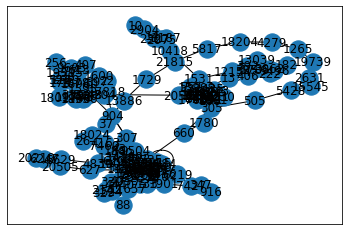

In [ ]:
subgraph_nodes1 = list(nx.dfs_preorder_nodes(graph, 10))[:150] #Gets 150 nodes in the graph that node 7 belongs to. 
print(subgraph_nodes1)
G1 = graph.subgraph(subgraph_nodes1)
pos = nx.spring_layout(G1, seed=42)
nx.draw_networkx(G1, pos=pos, cmap='coolwarm')

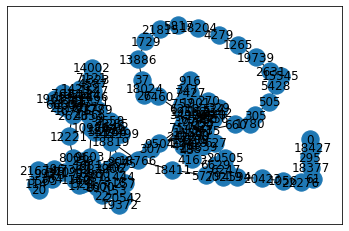

In [ ]:
subgraph_nodes2 = list(nx.dfs_preorder_nodes(graph))[:150] #Gets 150 nodes in the graph 
G2 = graph.subgraph(subgraph_nodes2)
pos = nx.spring_layout(G2, seed=42)
nx.draw_networkx(G2, pos=pos, cmap='coolwarm')

### Embedding graph using DeepWalk

If you want the code to run quicker, please use G1 or G2 instead of putting the whole graph in the walker. It will be a little bit trickier in processing data later but no worries.

In [ ]:
from karateclub.utils.walker import RandomWalker
from gensim.models.word2vec import Word2Vec
walker = RandomWalker(walk_number = 10, walk_length = 80)
walker.do_walks(G2)

In [ ]:
model = Word2Vec(walker.walks,  # previously generated walks
                 hs=1,  # tells the model to use hierarchical softmax
                 sg = 1,  # tells the model to use skip-gram
                 size=128,  # size of the embedding
                 window=5,
                 min_count=1,
                 workers=4,
                 seed=42)


In [ ]:
embeddings = model.wv.vectors
print('Shape of embedding matrix:', embeddings.shape)

Shape of embedding matrix: (150, 128)


Let's check the most similar nodes to a random node.

If you use the G1, please change subgraph_nodes2 to subgraph_nodes1.

If you use the whole graph, any ID can work. Would you mind trying it yourself?

In [ ]:
similar_to = str(subgraph_nodes2[random.randint(0, len(subgraph_nodes2)-1)])
print("Similar to ID {}".format(similar_to))
model.wv.most_similar(similar_to)
targets.loc[[int(similar_to)] + [int(v[0]) for v in model.wv.most_similar(similar_to)], :].head()

Similar to ID 2575


,id,facebook_id,page_name,page_type
id,,,,
2575,2575,513032565431680,Alexander Funk,politician
257,257,1131869050241771,Alex Zeyer,politician
20542,20542,53810387822,Volker Bouffier,politician
18819,18819,601163706652420,Niels Annen,politician
19372,19372,536275779902817,Björn Simon,politician


In [ ]:
similar_to = str(subgraph_nodes2[random.randint(0, len(subgraph_nodes2)-1)])
print("Similar to ID {}".format(similar_to))
targets.loc[[int(similar_to)] + [int(v[0]) for v in model.wv.most_similar(similar_to)], :].head()

Similar to ID 7460


,id,facebook_id,page_name,page_type
id,,,,
7460,7460,573990992631231,U.S. Department of Health and Human Services,government
26,26,136577286212,National Institute of General Medical Sciences,government
18024,18024,354081104645698,NIH Record,government
37,37,367794192480,NCBI - National Center for Biotechnology Infor...,government
13886,13886,123752877694785,KeVita,company


### Train a classifier

Train a classifier from the embedding graph to the target. Here we use the Random Forest classifier.

In [ ]:
# Get targets 
y = targets.loc[[int(i) for i in list(features.keys())], 'page_type']
print(y)
# Get corresponding embeddings
X_dw = []
co_oc = []
for i in y.index:
  if str(i) in model.wv:
    X_dw.append(model.wv.__getitem__(str(i)))
    co_oc.append(i)

y = targets.loc[[i for i in co_oc], 'page_type']
X_train, X_test, y_train, y_test = train_test_split(X_dw, y, test_size=0.2) # train/test split

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f1_score(y_test, y_pred, average='micro'))
print(confusion_matrix(y_test, y_pred, normalize='true'))

id
554      politician
10772    government
6350         tvshow
9218     government
7787     politician
            ...    
21828       company
1421     government
19147    politician
13411    politician
2750     government
Name: page_type, Length: 22470, dtype: object
0.8666666666666667
[[0.33333333 0.66666667 0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.4        0.6        0.        ]
 [0.         0.         0.         1.        ]]


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


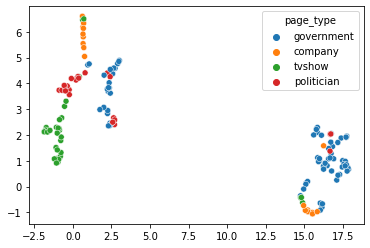

In [ ]:
u = umap.UMAP(random_state=42)
dw_umap_embs = u.fit_transform(X_dw)

ax = sns.scatterplot(x = dw_umap_embs[:, 0], y = dw_umap_embs[:, 1], hue = y)

# THANK YOU
Please dive more into the codes and papers if you are interested.

Thank you for joining all the labs.